In [ ]:
!pip install finance-datareader
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
import FinanceDataReader as fdr
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt


In [ ]:

def get_stocks(stock_dict) :
    new_dict = dict()
    for stock_code, stock_name in stock_dict.items():
        print(f"{stock_name} : {stock_code}")
        new_dict[stock_code] = fdr.DataReader(stock_code, '2011', '2024-05-08').reset_index()
        print(stock_name, " : ", new_dict[stock_code].shape)
    return new_dict

# 데이터 전처리
def preprocess_data(data):
    data['Date'] = pd.to_datetime(data['Date'])

    # Feature Scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.iloc[:, 1:])
    return scaled_data, scaler

# 데이터셋 생성
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

def calculate_benefits(predicts):
    results = {}
    #4일1회투자 최고이득
    max_benefit = -2.0
    max_target = None
    purchase_day = -1
    purchase = -10_000_000.0
    sale_day = -1
    sale = -10_000_000.0
    for stock_code, predict_data in predicts.items():
        for i in range(3):
            for j in range(i+1,4):
                max_data = predict_data['고가'][j]
                min_data = predict_data['저가'][i]
                if ((max_data - min_data) / min_data) > max_benefit:
                    max_target = stock_code
                    max_benefit = ((max_data - min_data)/min_data)
                    purchase_day = predict_data['저가'].index(min_data)
                    sale_day = predict_data['고가'].index(max_data)
                    purchase = min_data
                    sale = max_data
    results['4_1'] = {
        'target':max_target,
        'benefit':max_benefit,
        'purchase_day':purchase_day,
        'purchase':purchase,
        'sale_day':sale_day,
        'sale':sale
    }
    return results

def virtual_investment(budget, predicts,stock_data):
    results = calculate_benefits(predicts)
    dates = {
        0 : "2024-05-09",
        1: "2024-05-10",
        2: "2024-05-13",
        3: "2024-05-14",
    }
    #4_1
    print("-------------------------------------------")
    print("1번의 주식 투자, 최고의 선택")
    print("-------------------------------------------")
    result_data = results['4_1']
    if result_data['target'] != "" and result_data['benefit'] > 0:
        stock_name = stock_data[result_data['target']]
        purchase_stock = budget//result_data['purchase']
        unused_money = budget%result_data['purchase']
        comment = (f"종자돈 : {budget:,}원\n"
                   f"대 상 : {stock_name} (코드:{result_data['target']})\n"
                   f"{stock_name} {purchase_stock}주를 {dates[result_data['purchase_day']]}일에 구매\n"
                   f"{stock_name}의 1주 가격 : {result_data['purchase']}\n"
                   f"구매액 : {purchase_stock*result_data['purchase']:,.2f}원\n\n"
                   f"{stock_name} {purchase_stock}주를 {dates[result_data['sale_day']]}일에 판매\n"
                   f"{stock_name}의 1주 가격 : {result_data['sale']}\n"
                   f"판매액 : {purchase_stock*result_data['sale']:,.2f}원\n\n"
                   f"수익률 : +{result_data['benefit']*100:,.3f}%\n"
                   f"최종액 : {purchase_stock*result_data['sale'] + unused_money:,.2f}원\n")
    else :
        comment = (
            "투자로 수익이 나는 주식이 존재하지 않습니다\n"
        )

    print(comment)


def get_graph(predicts, stock_names):
    for stock_code, predict_data in predicts.items():
        print(stock_names[stock_code], ", ", stock_code)
        plt.plot([1,2,3,4], predict_data['저가'], label='predict_low')
        plt.plot([1,2,3,4], predict_data['고가'], label='predict_high')
        df = fdr.DataReader(stock_code, '2024-05-09', '2024-05-13').reset_index()
        plt.plot([1,2,3], list(df['Low']), label='real_low')
        plt.plot([1,2,3], list(df['High']), label='real_high')
        plt.xticks([1,2,3,4],['05/09','05/10','05/13','05/14'])
        plt.xlabel("day")
        plt.ylabel("stock")
        plt.title(stock_code)
        plt.legend()
        plt.show()



def predict_finance():
    start_time = time.time()
    # 주식 코드
    target_stocks = {
        # '443060':'HD현대마린솔루션', #일별데이터가 너무 적어 제외
        '005930': '삼성전자',
        '028300': 'HLB',
        '035420': 'NAVER',
        '006340': '대원전선',
        '348370': '엔켐',
        '034020': '두산에너빌리티',
        '039980': '폴라리스AI',
        '011200': 'HMM',
        '035720': '카카오',
        '042700': '한미반도체',
    }
    predicts = {}
    stock_datas = get_stocks(target_stocks)
    # 주식 정보 가져오기
    for stock_code, stock_name in target_stocks.items():
        dataset = stock_datas[stock_code]
        dataset = dataset.rename(columns={
            'Open': '시가',
            'High': '고가',
            'Low': '저가',
            'Close': '종가',
            'Volume': '거래량',
            'Change': '변동률',
        }).fillna({'변동률': 0})
        forecasts = {}
        for names in ['고가','저가']:
            model = auto_arima(dataset[names], seasonal=True, # sarima(seasonal=True)
                             d=1, D=1,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False)
            forecasts[names] = model.predict(n_period=4)
        finance_data = {data_types:forecasts[data_types][:4].tolist() for data_types in ['고가','저가']}
        predicts[stock_code] = finance_data

    virtual_investment(10_000_000, predicts, target_stocks)

    get_graph(predicts, target_stocks)
    print(f"전체 작업 진행 시간 : {time.time() - start_time}s")

삼성전자 : 005930
삼성전자  :  (3288, 7)
HLB : 028300
HLB  :  (3288, 7)
NAVER : 035420
NAVER  :  (3288, 7)
대원전선 : 006340
대원전선  :  (3288, 7)
엔켐 : 348370
엔켐  :  (621, 7)
두산에너빌리티 : 034020
두산에너빌리티  :  (3288, 7)
폴라리스AI : 039980
폴라리스AI  :  (3288, 7)
HMM : 011200
HMM  :  (3288, 7)
카카오 : 035720
카카오  :  (3288, 7)
한미반도체 : 042700
한미반도체  :  (3288, 7)
 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=57384.254, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=57386.151, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=57385.532, Time=0.75 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=56657.272, Time=1.11 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=56658.198, Time=1.28 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=56658.946, Time=1.56 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=57386.153, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=57339.703, Time=3.07 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=57199.295, Time=4.65 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=56658.199, Time=1.65 s

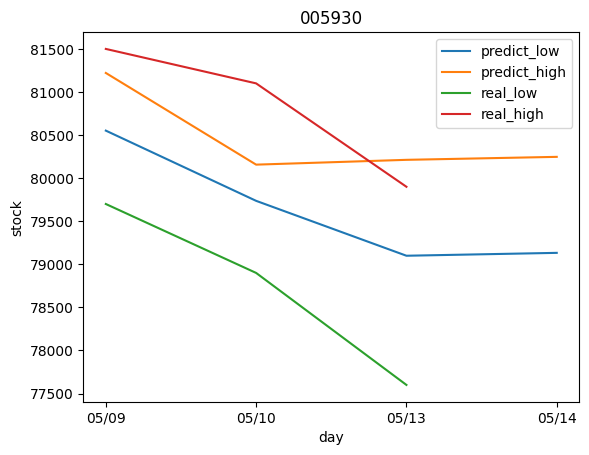

HLB ,  028300


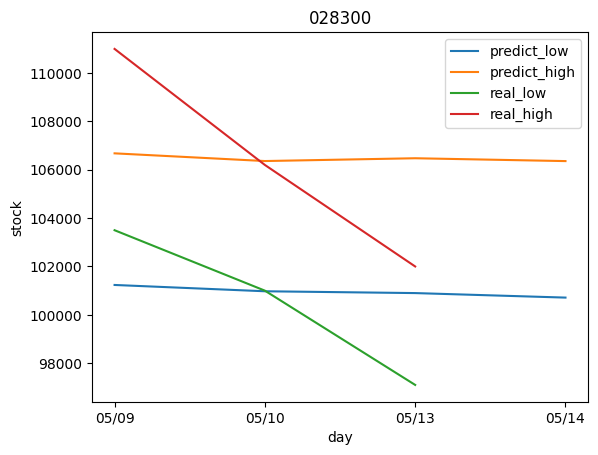

NAVER ,  035420


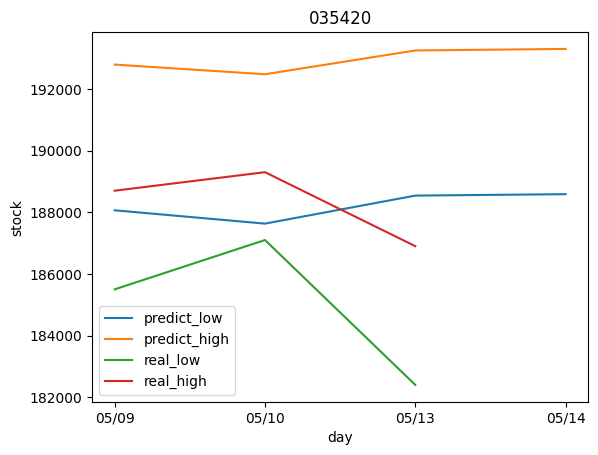

대원전선 ,  006340


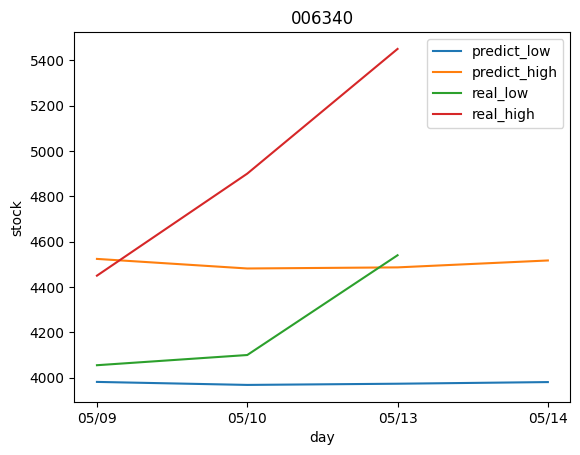

엔켐 ,  348370


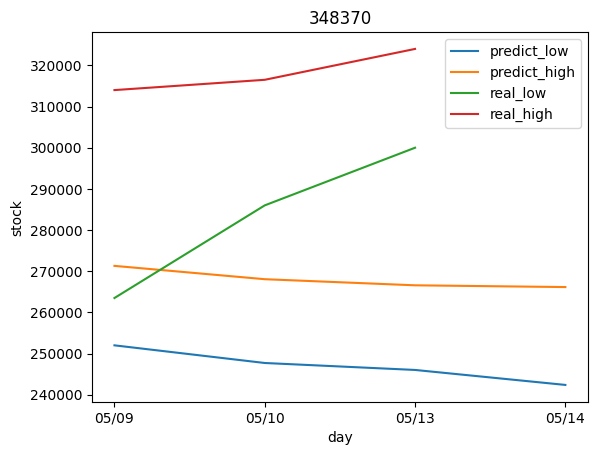

두산에너빌리티 ,  034020


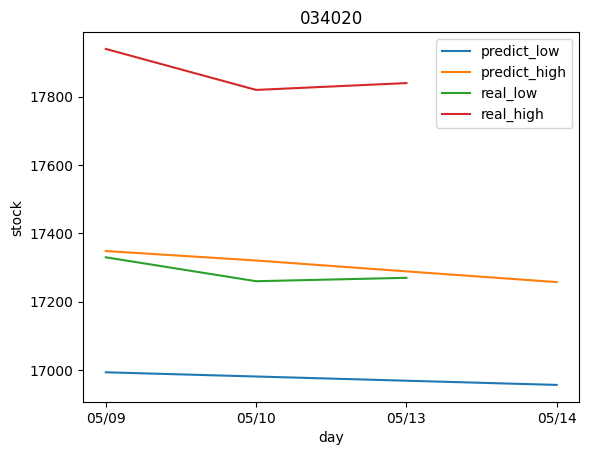

폴라리스AI ,  039980


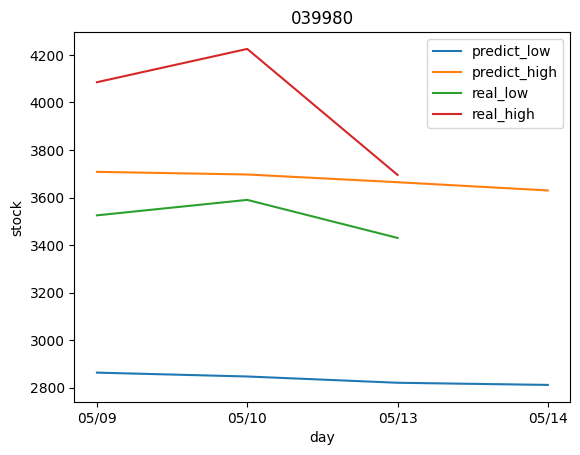

HMM ,  011200


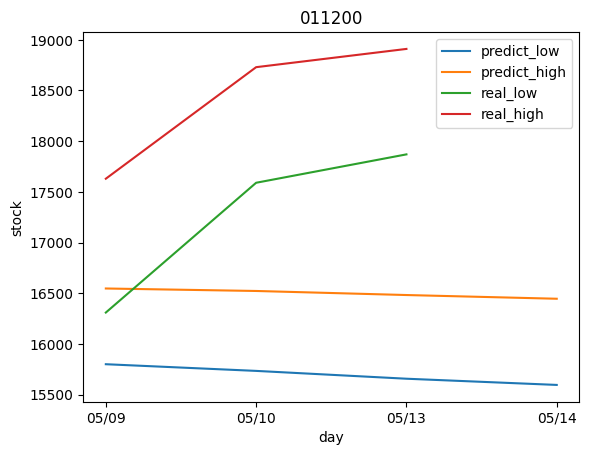

카카오 ,  035720


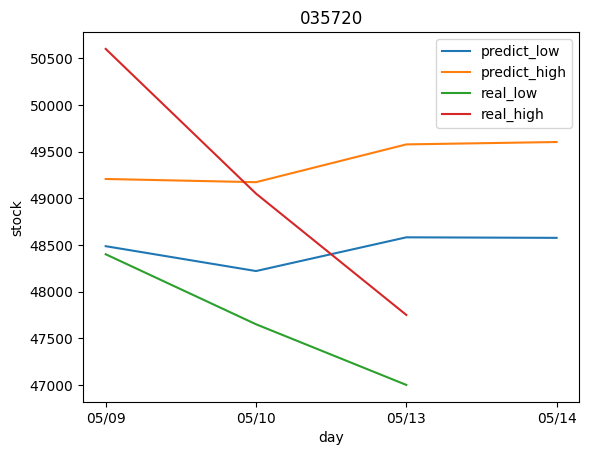

한미반도체 ,  042700


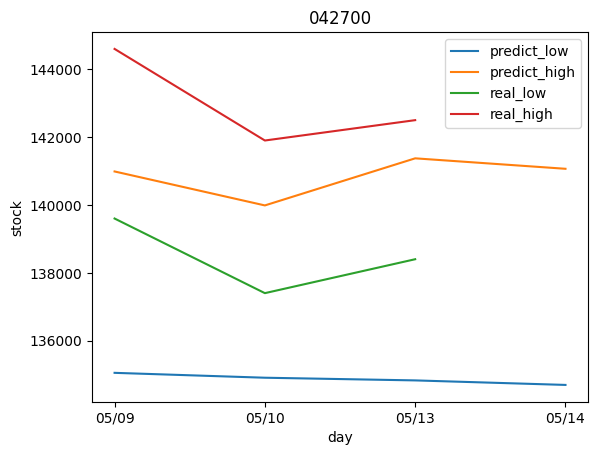

전체 작업 진행 시간 : 827.3270530700684s


In [ ]:
predict_finance()